<a href="https://colab.research.google.com/github/himanshuchrist/AI-ML/blob/ML_Lab/Lab4_2348520.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import threading
import warnings
warnings.filterwarnings('ignore')
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

In [8]:
#loading the data set
data=pd.read_csv('/content/drive/MyDrive/Groceries_dataset.csv')
data.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [9]:
#creating new column and assigning value 1 to every row
data['Quantity']=1

In [10]:
#creating new dataframe with distinct items as columns and memeber number as rows
transactions=data.groupby(['Member_number','itemDescription'])['Quantity'].sum().unstack().reset_index().set_index('Member_number')

In [11]:
#assigning 0 to all null values
transactions=transactions.fillna(0)

In [12]:
#converting the dataframe into 0s and 1s
def encode(x):
  if x<=0:
    return 0
  elif x>=0:
    return 1
transactionsdf=transactions.applymap(encode)

In [13]:
#initializing the event object for inter-thread communication
aprioricompleted=threading.Event()
fpcompleted=threading.Event()

In [14]:
#setting execution time for both algorithms as 0
executiontime=[0,0]

In [15]:
#creating a function to execute apriori algorithm with used input values and displaying the best choices
def runapi(support,confidence):
  stime=time.time()
  aprioriresults=apriori(transactionsdf,min_support=support,use_colnames=True)
  rules=association_rules(aprioriresults,metric='confidence',min_threshold=confidence)
  bestchoice=rules.sort_values(by='lift',ascending=False)
  print("According to Apriori Best choices are")
  print(bestchoice[['antecedents','consequents','lift']][:10])
#storing the time taken by apriori to complete the execution
  executiontime[0]=time.time()-stime
#sets the internal flag to true, awakening all the waiting threads.
  aprioricompleted.set()

In [16]:
#creating a function to execute apriori algorithm with used input values and displaying the best choices
def runfp(support,confidence):
  stime=time.time()
  fpresults=fpgrowth(transactionsdf,min_support=support,use_colnames=True)
  rules=association_rules(fpresults,metric='confidence',min_threshold=confidence)
  bestchoice=rules.sort_values(by='lift',ascending=False)
  print("According to FP Growth Best choices are")
  print(bestchoice[['antecedents','consequents','lift']][:10])
  #storing the time taken by apriori to complete the execution
  executiontime[1]=time.time()-stime
  #sets the internal flag to true, awakening all the waiting threads.
  fpcompleted.set()

In [17]:
#user input for support and confidence and calling both the functions
support=float(input("Enter minimum support: "))
confidence=float(input("Enter confidence threshold: "))
apithread=threading.Thread(target=runapi(support,confidence))
fpthread=threading.Thread(target=runfp(support,confidence))

Enter minimum support: 0.005
Enter confidence threshold: 0.2
According to Apriori Best choices are
                                 antecedents                  consequents  \
21911      (rolls/buns, brown bread, yogurt)  (shopping bags, whole milk)   
21914    (shopping bags, rolls/buns, yogurt)    (brown bread, whole milk)   
21909      (brown bread, yogurt, whole milk)  (shopping bags, rolls/buns)   
23147               (soda, pork, whole milk)    (root vegetables, yogurt)   
23153        (pork, root vegetables, yogurt)           (soda, whole milk)   
21899        (soda, brown bread, whole milk)  (shopping bags, rolls/buns)   
13703                    (canned beer, curd)    (brown bread, whole milk)   
13801                  (shopping bags, curd)    (brown bread, whole milk)   
12270               (bottled water, chicken)         (butter, whole milk)   
16288  (rolls/buns, root vegetables, coffee)                (frankfurter)   

           lift  
21911  3.703486  
21914  3.363370  

In [18]:
#starting the thread
apithread.start()
fpthread.start()
#making thread wait until the execution of set() is not done
aprioricompleted.wait()
fpcompleted.wait()
#blocking the calling thread until the thread object gets terminated
apithread.join()
fpthread.join()

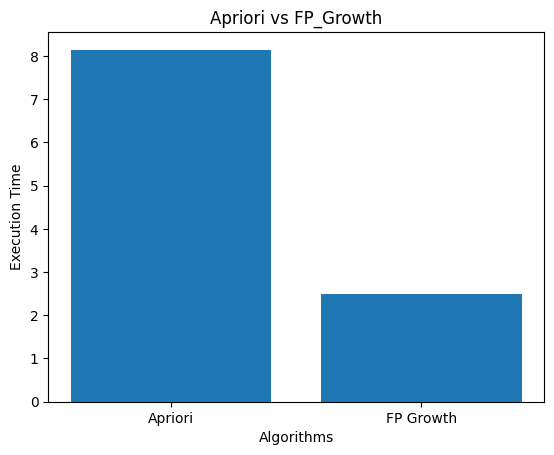

FP_Growth is faster


In [19]:
#plotting the results of both the algorithms and deciding the best fit
algorithms=['Apriori','FP Growth']
plt.bar(algorithms,executiontime)
plt.xlabel('Algorithms')
plt.ylabel('Execution Time')
plt.title('Apriori vs FP_Growth')
plt.show()
if executiontime[0]<executiontime[1]:
  print("Apriori is faster")
elif executiontime[0]>executiontime[1]:
  print("FP_Growth is faster")
else:
  print("Both are equal")